## DARIMA Algorithm Notebook

* spark 3.5.0
* pyspark 3.5.0
* python 3.11.5 (anaconda env)
* R 4.3.2
* rpy2 3.5.14
* java jdk 17.0

### Importing

In [3]:
import findspark
findspark.init()

import pyspark
# Set Executor Env
conf = pyspark.SparkConf().setAppName("Spark DARIMA App").setExecutorEnv('ARROW_PRE_0_15_IPC_FORMAT', '1')
spark = pyspark.sql.SparkSession.builder.config(conf=conf).getOrCreate()
#spark = pyspark.sql.SparkSession.builder.appName("Spark DARIMA App").getOrCreate()
#spark.sparkContext.addPyFile("darima.zip")

import os, sys, time
from datetime import timedelta

# from hurry.filesize import size
import pickle
import numpy as np
import pandas as pd
import string
from math import ceil

from pyspark.sql.types import *
from pyspark.sql import functions
from pyspark.sql.functions import udf, pandas_udf, PandasUDFType, monotonically_increasing_id

from darima.model import sarima2ar_model, darima_model
from darima.dlsa import dlsa_mapreduce
from darima.forecast import forecast_darima, darima_forec
from darima.evaluation import model_eval

import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri

### Setting and initiallization

In [4]:
# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.pyspark.fallback.enabled", "true")


##----------------------------------------------------------------------------------------
## SETTINGS
##----------------------------------------------------------------------------------------

# General settings
#-----------------------------------------------------------------------------------------
using_data = "real_hdfs" # ["simulated_pdf", "real_pdf", "real_hdfs"
series_name = 'TOTAL'
model_saved_file_name = 'result/darima_model_' + series_name + '_' + time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime()) + '.pkl'
coef_saved_file_name = 'result/darima_coef_' + series_name + '_' + time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime()) + '.csv'

# Model settings
#-----------------------------------------------------------------------------------------
period = 24 # Seasonality
tol = 2000
order = [0,0,0]; seasonal = [0,0,0]
max_p = 5; max_q = 5; max_P = 2; max_Q = 2
max_order = 5; max_d = 2; max_D = 1
allowmean = True; allowdrift = True
method = "CSS" # Fitting method
approximation = False; stepwise = True
parallel = False; num_cores = 2
h = 2879; level = 95

# Settings for using real hdfs data
#-----------------------------------------------------------------------------------------
file_train_path = ['data/' + series_name + '_train.csv'] # HDFS file
file_test_path = ['data/' + series_name + '_test.csv'] # HDFS file
forec_saved_file_name = 'result/darima_forec_' + series_name + '_' + time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime()) + '.csv'

usecols_x = ['time']

schema_sdf = StructType([
    StructField('demand', DoubleType(), True),
    StructField('time', StringType(), True)
])
# s = spark.read.schema("col0 INT, col1 DOUBLE")

n_files = len(file_train_path)
partition_num = [150]*n_files # Number of partition subseries
## max_sample_size_per_sdf = 10000 # No effect with `real_hdfs` data
sample_size_per_partition = []

Y_name = "demand"
sample_size = []

# Read or load data chunks into pandas
#-----------------------------------------------------------------------------------------
time_2sdf = []
# time_repartition = []
file_no_i = 0
tic_2sdf = time.perf_counter()

## Using HDFS data
## ------------------------------
isub = 0 # fixed, never changed

# Read HDFS to Spark DataFrame
data_sdf_i = spark.read.csv(file_train_path[file_no_i], header=True, schema=schema_sdf)
data_sdf_i = data_sdf_i.select(usecols_x + [Y_name])
data_sdf_i = data_sdf_i.dropna()

data_test_sdf = spark.read.csv(file_test_path[file_no_i], header=True, schema=schema_sdf)

# Calculate sample size of per partition (except the last sample)
sample_size.append(data_sdf_i.count())
sample_size_per_partition.append(int(sample_size[file_no_i] / partition_num[file_no_i]))

# Add ID
data_sdf_i = data_sdf_i.withColumn(
    "id",
    monotonically_increasing_id()+1)
# typecasting to int
data_sdf_i = data_sdf_i.withColumn("id",data_sdf_i['id'].cast('int'))

# Add partition ID according to ID
def partition_id(idvalue: int):
    if ceil(idvalue/sample_size_per_partition[file_no_i]) <= partition_num[file_no_i]:
        return ceil(idvalue/sample_size_per_partition[file_no_i])
    else:
        return partition_num[file_no_i]

udf_partition_id = udf(partition_id, IntegerType())
data_sdf_i = data_sdf_i.withColumn("partition_id", udf_partition_id("id"))
# data_sdf_i.groupby("partition_id").count().show() # Verify results of udf_partition_id
data_sdf_i = data_sdf_i.select([Y_name] + ["partition_id"]) # Only select demand and partition_id
# data_sdf_i = data_sdf_i.select(usecols_x + [Y_name] + ["partition_id"]) # Delete ID

time_2sdf.append(time.perf_counter() - tic_2sdf)

### Modeling on partitioned data

In [5]:
##----------------------------------------------------------------------------------------
## MODELING ON PARTITIONED DATA
##----------------------------------------------------------------------------------------
'''
tic_repartition = time.perf_counter()
data_sdf_i = data_sdf_i.repartition(partition_num[file_no_i], "partition_id")
time_repartition.append(time.perf_counter() - tic_repartition)
'''
# Register a user defined function via the Pandas UDF
#-----------------------------------------------------------------------------------------
usecoef_ar = ['c0', 'c1'] + ["pi" + str(i+1) for i in np.arange(tol)]
schema_fields = []
for i in usecoef_ar:
    schema_fields.append(StructField(i, DoubleType(), True))

## standard output version
#schema_beta = StructType(
#    [StructField('par_id', IntegerType(), True),
#     StructField('coef', DoubleType(), True),
#     StructField('Sig_invMcoef', DoubleType(), True)]
#    + schema_fields)

# simplified output version
schema_beta = StructType(
    [StructField('par_id', IntegerType(), True),
     StructField('Sig_inv_value', DoubleType(), True)]
    + schema_fields)

@pandas_udf(schema_beta, PandasUDFType.GROUPED_MAP)
def darima_model_udf(sample_df):
    return darima_model(sample_df = sample_df, Y_name = Y_name, period = period, tol = tol,
                order = order, seasonal = seasonal,
                max_p = max_p, max_q = max_q, max_P = max_P, max_Q = max_Q,
                max_order = max_order, max_d = max_d, max_D = max_D,
                allowmean = allowmean, allowdrift = allowdrift, method = method,
                approximation = approximation, stepwise = stepwise,
                parallel = parallel, num_cores = num_cores)

# Partition the data and run the UDF
#-----------------------------------------------------------------------------------------
model_mapped_sdf = data_sdf_i.groupby("partition_id").apply(darima_model_udf)
#tic_map = time.perf_counter()
model_mapped_sdf.show()
#time_map = time.perf_counter() - tic_map

c:\ProgramData\Anaconda3\envs\python3115\Lib\site-packages\pyspark\sql\pandas\group_ops.py:104: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


+------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------

### Aggregating the model estimates

In [6]:
##----------------------------------------------------------------------------------------
## AGGREGATING THE MODEL ESTIMATES
##----------------------------------------------------------------------------------------

# Obtain Sig_tilde and Theta_tilde
sample_size = sum(sample_size)

tic_mapred = time.perf_counter()
Sig_Theta = dlsa_mapreduce(model_mapped_sdf, sample_size) # Pandas DataFrame
time_mapred = time.perf_counter() - tic_mapred

### Forecasting

In [7]:
##----------------------------------------------------------------------------------------
## FORECASTING
##----------------------------------------------------------------------------------------
data_train = data_sdf_i.toPandas()["demand"]
out_Theta = Sig_Theta["Theta_tilde"]
out_Sigma = Sig_Theta[usecoef_ar]

tic_model_forec = time.perf_counter()

out_model_forec = darima_forec(Theta = out_Theta, Sigma = out_Sigma,
                          x = data_train, period = period,
                          h = h, level = level)

time_model_forec = time.perf_counter() - tic_model_forec

### Evaluation

In [8]:
##----------------------------------------------------------------------------------------
## EVALUATION
##----------------------------------------------------------------------------------------
data_test = data_test_sdf.toPandas()["demand"]
pred = out_model_forec["pred"]
lower = out_model_forec["lower"]
upper = out_model_forec["upper"]

tic_model_eval = time.perf_counter()

out_model_eval = model_eval(x = data_train, xx = data_test, period = period,
                            pred = pred, lower = lower, upper = upper, level = level)

time_model_eval = time.perf_counter() - tic_model_eval

score = out_model_eval.mean(axis=0)

### Print some results

In [9]:
##----------------------------------------------------------------------------------------
## PRINT OUTPUT
##----------------------------------------------------------------------------------------
#partition_num = sum(partition_num)
# time_repartition = sum(time_repartition)
# time_2sdf = sum(time_2sdf)
# sample_size_per_partition = sample_size / partition_num

out_time = pd.DataFrame({
    "sample_size": sample_size,
    "sample_size_per_partition": sample_size_per_partition,
    "n_par": len(schema_beta) - 3,
    "partition_num": partition_num,
    # "time_2sdf": time_2sdf,
    # "time_repartition": time_repartition,
    #"time_map": time_map,
    "time_mapred": time_mapred,
    # "time_dlsa": time_dlsa,
    "time_model_forec": time_model_forec,
    "time_model_eval": time_model_eval}, index=[0])

# save the model to pickle, use pd.read_pickle("test.pkl") to load it.
out = [Sig_Theta, out_model_forec, out_model_eval, out_time]
#pickle.dump(out, open(os.path.expanduser(model_saved_file_name), 'wb'))
with open(model_saved_file_name, 'wb+') as f:
    pickle.dump(out,f)
print("Model results are saved to:\t" + model_saved_file_name)

# save the Sig_Theta to csv.
Sig_Theta.to_csv(coef_saved_file_name, index=False)
print("Coefficient results are saved to:\t" + coef_saved_file_name)

# save the point forecasts and prediction intervals to csv.
out_model_forec.to_csv(forec_saved_file_name, index=False)
print("Forecasting results are saved to:\t" + forec_saved_file_name)

#print("End")

Model results are saved to:	result/darima_model_TOTAL_2023-12-25-08_21_29.pkl
Coefficient results are saved to:	result/darima_coef_TOTAL_2023-12-25-08_21_29.csv
Forecasting results are saved to:	result/darima_forec_TOTAL_2023-12-25-08-21-29.csv


In [10]:
# print time.
print("\nModel Summary:\n")
print(out_time.to_string(index=False))


Model Summary:

 sample_size  sample_size_per_partition  n_par  partition_num  time_mapred  time_model_forec  time_model_eval
      121292                        808   2001            150    361.79931          8.074947         0.088901


In [11]:
print("\nDLSA Coefficients:\n")
print(out_Theta.to_string(index=False))


DLSA Coefficients:

-2.374391e-01
 5.834515e-13
 2.096907e+00
-1.852682e+00
 1.071362e+00
-4.321458e-01
 8.125623e-02
 3.290773e-02
-2.030092e-02
-3.193518e-02
 7.102881e-02
-7.199125e-02
 5.000775e-02
-3.297168e-02
 3.175599e-02
-3.446068e-02
 3.181981e-02
-2.803144e-02
 2.774130e-02
-2.732449e-02
 2.273569e-02
-1.775142e-02
 1.785258e-02
-2.077293e-02
 2.080502e-02
 5.841092e-01
-1.239108e+00
 1.086410e+00
-6.197447e-01
 2.410016e-01
-3.429256e-02
-3.257229e-02
 2.602830e-02
 5.628952e-03
-3.202689e-02
 3.560040e-02
-2.306824e-02
 1.222645e-02
-1.159881e-02
 1.386251e-02
-1.207628e-02
 9.088948e-03
-9.190288e-03
 1.061523e-02
-9.382847e-03
 6.506026e-03
-5.839953e-03
 7.338703e-03
-7.874102e-03
-8.228464e-02
 1.749182e-01
-1.451983e-01
 7.474383e-02
-2.246325e-02
-2.451380e-03
 8.714877e-03
-8.404526e-03
 5.635665e-03
-1.600468e-03
-1.654960e-03
 2.132583e-03
-6.276516e-04
-2.868671e-05
-7.460426e-04
 9.050484e-04
 4.235774e-04
-1.640468e-03
 9.714779e-04
 6.002420e-04
-1.046402e-03

In [12]:
print("\nForecasting scores:\n")
print("mase, smape, msis\n")
print(score.to_string(index=False))


Forecasting scores:

mase, smape, msis

 1.253801
 8.179621
14.997018


### Plots

In [34]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt

In [43]:
df = pd.read_csv(os.path.join('data','TOTAL_test.csv'))
df['time'] = pd.to_datetime(df['time'])
df['pred'] = pred
df['lower'] = lower
df['upper'] = upper
df.set_index('time', inplace=True)
df.head()

,demand,pred,lower,upper
time,,,,
2017-01-01 00:00:00,11719.496,11770.021793,11502.704009,12037.339576
2017-01-01 01:00:00,11199.862,11389.314550,10768.295580,12010.333519
2017-01-01 02:00:00,10795.873,11185.464334,10264.451762,12106.476907
2017-01-01 03:00:00,10588.476,11158.392244,10017.047241,12299.737248
2017-01-01 04:00:00,10570.824,11333.865191,10026.090339,12641.640044


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2879 entries, 2017-01-01 00:00:00 to 2017-04-30 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   demand  2879 non-null   float64
 1   pred    2879 non-null   float64
 2   lower   2879 non-null   float64
 3   upper   2879 non-null   float64
dtypes: float64(4)
memory usage: 112.5 KB


<Axes: xlabel='time', ylabel='demand'>

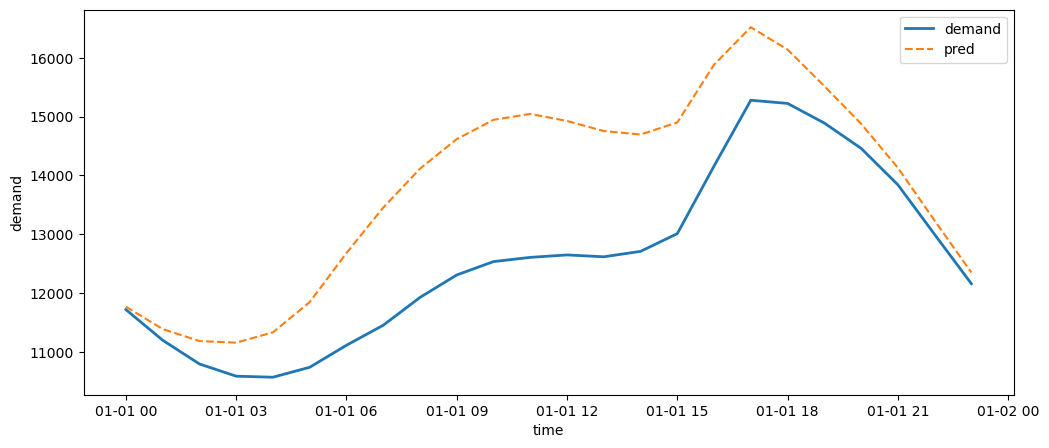

In [61]:
df_2 = df.copy()
df_2 = df_2.loc['2017-01-01']

fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(data=df_2, x='time', y='demand', label='demand', linewidth=2)
sns.lineplot(data=df_2, x='time', y='pred', label='pred', linestyle='--')